# Basic examples with PyTorch

- Tensor manipulations
- Variables and `autograd`
- Optimization toy example
- Neural network architecture example

Links:
- [API](http://pytorch.org/docs/master/index.html)
- [nn tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)
- [pytorch-notes](https://ikhlestov.github.io/pages/machine-learning/pytorch-notes)

In [1]:
import torch
import numpy as np

In [2]:
torch.__version__

'0.2.0_3'

## Tensors

> A [`torch.Tensor`](http://pytorch.org/docs/master/tensors.html) is a multi-dimensional matrix containing elements of a single data type.

> Each tensor has an associated [`torch.Storage`](http://pytorch.org/docs/master/storage.html), which holds its data.

[8 CPU/GPU types](http://pytorch.org/docs/master/tensors.html): `float`, `double`, `half` (16-bit floating), `integer` (signed, unsigned) (8-bits, 16-bits), `long` 



Let's create a tensor: x

In [3]:
x = np.array([[0, 1, 2, 3], [2, 3, 4, 5]])
x = torch.from_numpy(x)
print(x)


 0  1  2  3
 2  3  4  5
[torch.LongTensor of size 2x4]



Let's compute some metrics using PyTorch

In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [17]:
y_true = np.array([0, 0, 0, 1, 1, 2, 2, 2])
y_pred = np.array([
    [0.7, 0.3, 0],  # OK
    [0.1, 0.6, 0.3], # NOK
    [0.8, 0.2, 0.0], # OK
    [0.55, 0.15, 0.3], # NOK
    [0.2, 0.6, 0.2], # OK 
    [0.1, 0.1, 0.8], # OK
    [0.1, 0.2, 0.7], # OK
    [0.1, 0.7, 0.2], # NOK
])

In [6]:
# def numpy_tp(y_true, y_pred):
#     y_pred = np.round(np.clip(y_pred, 0.0, 1.0))
#     return np.sum(np.round(np.clip(y_true * y_pred, 0.0, 1.0))).astype(np.int)

# def numpy_fp(y_true, y_pred):
#     predicted_positives = np.sum(np.round(np.clip(y_pred, 0.0, 1.0))).astype(np.int)
#     return predicted_positives - numpy_tp(y_true, y_pred)

# def numpy_fn(y_true, y_pred):
#     y_pred = np.round(np.clip(y_pred, 0.0, 1.0))
#     possible_positives = np.sum(np.round(np.clip(y_true, 0, 1))).astype(np.int)
#     return possible_positives - numpy_tp(y_true, y_pred)

In [7]:
# print("TP, FP, FN : ", numpy_tp(y_true, y_pred), numpy_fp(y_true, y_pred), numpy_fn(y_true, y_pred))
# print("Precision: ", numpy_tp(y_true, y_pred) / (numpy_tp(y_true, y_pred) + numpy_fp(y_true, y_pred) + 1e-10))
# print("Recall: ", numpy_tp(y_true, y_pred) / (numpy_tp(y_true, y_pred) + numpy_fn(y_true, y_pred) + 1e-10))

TP, FP, FN :  5 3 3
Precision:  0.624999999992
Recall:  0.624999999992


In [8]:
precision_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='micro')

0.625

In [9]:
recall_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='micro')

0.625

In [16]:
accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

0.625

Pay attention to type conversions

In [10]:
def tp_f(y_true, y_pred):
    y_pred = torch.round(torch.clamp(y_pred, 0.0, 1.0)).long()
    return torch.sum(y_true * y_pred)


def fp_f(y_true, y_pred):
    predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0.0, 1.0)).long())
    return predicted_positives - tp_f(y_true, y_pred)


def precision(y_true, y_pred):
    tp_score = tp_f(y_true, y_pred)
    predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0.0, 1.0)).long())
    return tp_score / (predicted_positives + 1e-10)


def recall(y_true, y_pred):
    tp_score = tp_f(y_true, y_pred)
    possible_positives = torch.sum(torch.clamp(y_true, 0, 1))
    return tp_score / (possible_positives + 1e-10)


def accuracy(y_true, y_pred):
    

In [11]:
y_true_th = torch.from_numpy(y_true)
y_pred_th = torch.from_numpy(y_pred)
y_true_th.type(), y_pred_th.type()

('torch.LongTensor', 'torch.DoubleTensor')

Display tensor shape:

In [12]:
y_true_th.size(), y_pred_th.size(), 

(torch.Size([8, 3]), torch.Size([8, 3]))

In [13]:
_tp = tp_f(y_true_th, y_pred_th)
_fp = fp_f(y_true_th, y_pred_th)

In [14]:
print("TP, FP : ", _tp, _fp)
print("Precision : ", precision(y_true_th, y_pred_th))
print("Recall : ", recall(y_true_th, y_pred_th))

TP, FP :  5 3
Precision :  0.6249999999921875
Recall :  0.6249999999921875


Let's check if CUDA is available

In [162]:
assert torch.cuda.is_available()

Let's compute same stuff on GPU : 

- Pass tensor from CPU to GPU : x.cuda()
- Pass tensor from GPU to CPU : x.cpu()


To choose a device, one uses : 
```
with torch.cuda.device(0):
    pass
```

> Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a `pin_memory()` method, that returns a copy of the object, with data put in a pinned region.

> Also, once you pin a tensor or storage, you can use asynchronous GPU copies. Just pass an additional `async=True` argument to a `cuda()` call. This can be used to overlap data transfers with computation.

In [164]:
y_true_cuda = y_true_th.cuda()
y_pred_cuda = y_pred_th.cuda()

In [167]:
y_true_cuda.type(), y_true_th.type()

('torch.cuda.LongTensor', 'torch.LongTensor')

In [170]:
print("Precision : ", precision(y_true_cuda, y_pred_cuda))
print("Recall : ", recall(y_true_cuda, y_pred_cuda))

Precision :  0.6249999999921875
Recall :  0.6249999999921875


## Variables

Story on automatic gradient computation wrt variables

Let's create a quadratic function $y(x)$ and compute a gradient

In [6]:
from torch.autograd import Variable

In [128]:
x = Variable(torch.FloatTensor([0, 1, 2, 3, 4, 5]), requires_grad=True)
y = torch.sum(torch.pow(x, 2.0) + 3.0 * x + 1.0)

Visualize variable graph. Code taken from [here](https://github.com/szagoruyko/functional-zoo/blob/master/visualize.py)

In [9]:
from graphviz import Digraph


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

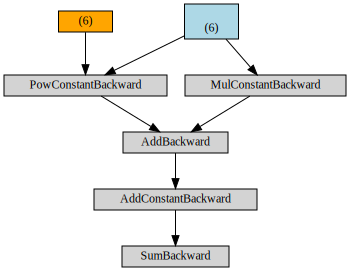

In [130]:
make_dot(y)

In [131]:
y

Variable containing:
 106
[torch.FloatTensor of size 1]

Compute gradients $\frac{\partial y}{\partial x}$ for initial values of $x$. Analytical derivative of $y(x) = x^2 + 3 x + 1$ is $y' = 2 x + 3$

In [132]:
y.backward()

In [133]:
x.grad.data.numpy()  # gradients dy/dx

array([  3.,   5.,   7.,   9.,  11.,  13.], dtype=float32)

### Toy minimization loss function example

Let's consider a very basic minimization example: we have 2-dimensional $\mathbf{x}$ samples and labels $y$, prediction model
$$
    y^{i}_{pred} = W \cdot \mathbf{x}_i,
$$
where $W=(w_1, w_2)$. 

Let's introduce Mean Square Error loss function as
$$
    loss = \sum_i (y^i - y^i_{pred})^2
$$

Optimization procedure to find parameters $W$ that minimize the loss function is 
- Process input through the model
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the model’s parameters
- Update the weights of the model, typically using a simple update rule: 
```
W = W - learning_rate * gradient
```

References:
- [understanding-how-torch-nn-module-works](https://discuss.pytorch.org/t/understanding-how-torch-nn-module-works/122/5)

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

In [17]:
x = Variable(torch.FloatTensor([[1.0, 1.0], 
                                 [1.0, 2.1], 
                                 [1.0, 3.6], 
                                 [1.0, 4.2], 
                                 [1.0, 6.0], 
                                 [1.0, 7.0]]))
y = Variable(torch.FloatTensor([1.0, 2.1, 3.6, 4.2, 6.0, 7.0]))

In [18]:
x.size(), y.size()

(torch.Size([6, 2]), torch.Size([6]))

In [21]:
weights = Variable(torch.zeros((2,
)), requires_grad=True)
net_output = x.mv(weights)
make_dot(net_output)
net_output.size()

torch.Size([6])

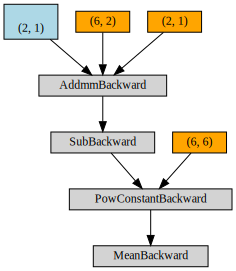

In [290]:
loss = torch.mean((net_output - y)**2)
make_dot(loss)

Let's manually perform this procedure:

n_iter 499
0.31197017431259155 0.31197020411491394
y_pred:  Variable containing:
 1.0087
 1.9375
 3.2039
 3.7105
 5.2303
 6.0746
[torch.FloatTensor of size 6]

Weights :  Variable containing:
 0.1645
 0.8448
[torch.FloatTensor of size 2]



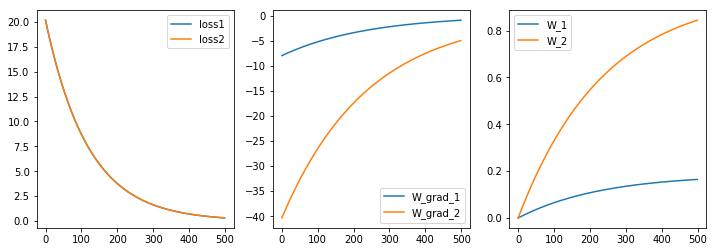

In [23]:
mse_loss = nn.MSELoss()
weights = Variable(torch.zeros((2,)).float(), requires_grad=True)

n = 500
loss1 = []
loss2 = []
weights_grads_history = np.zeros((n, 2))
weights_history = np.zeros((n, 2))
learning_rate = 0.0001

for i in range(n):

    y_pred = x.mv(weights)
    loss = torch.mean((y - y_pred)**2.0)
    loss_ = mse_loss(y_pred, y)    
    loss1.append(loss.data[0])
    loss2.append(loss_.data[0])
    # Compute gradients
    loss.backward()
    
    # Update parameters
    weights_grads_history[i, :] = weights.grad.data.numpy()
    weights_history[i, :] = weights.data.numpy()
    weights.data.sub_(weights.grad.data * learning_rate)

    # You need to clear the existing gradients though, else gradients will be accumulated to existing gradients         
    weights.grad.data.zero_()

    
print("n_iter", i)
print(loss1[-1], loss2[-1])
print("y_pred: ", y_pred)
print("Weights : ", weights)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(range(n), loss1, label='loss1')
plt.plot(range(n), loss2, label='loss2')
_ = plt.legend()
plt.subplot(132)
plt.plot(range(n), weights_grads_history[:, 0], label='W_grad_1')
plt.plot(range(n), weights_grads_history[:, 1], label='W_grad_2')
plt.legend()
plt.subplot(133)
plt.plot(range(n), weights_history[:, 0], label='W_1')
plt.plot(range(n), weights_history[:, 1], label='W_2')
_ = plt.legend()

Now let's perform the optimization with PyTorch tools:

- Neural network module
- Mean Square Error loss function
- SGD optimizer

In [15]:
from torch import nn
from torch import optim

class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.weights = nn.Parameter(torch.zeros((2, 1)))
        
    def forward(self, x):
        return x.mm(self.weights)
        
toy = ToyModel()
mse_loss = nn.MSELoss()

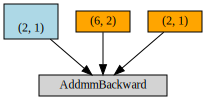

In [210]:
output = toy(x)
make_dot(output)

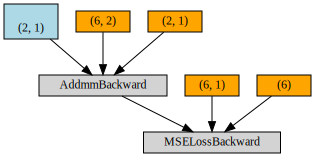

In [211]:
loss = mse_loss(output, y)
make_dot(loss)

n_iter 499
0.31197020411491394
Net output:  Variable containing:
 1.0087
 1.9375
 3.2039
 3.7105
 5.2303
 6.0746
[torch.FloatTensor of size 6x1]

Weights :  Parameter containing:
 0.1645
 0.8448
[torch.FloatTensor of size 2x1]



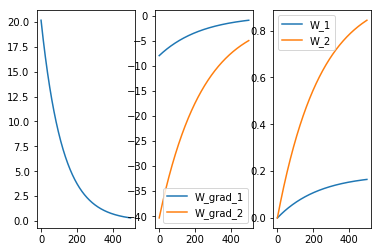

In [201]:
n = 500
loss1 = []
weights_grads_history = np.zeros((n, 2))
weights_history = np.zeros((n, 2))
learning_rate = 0.0001

for i in range(n):
    # You need to clear the existing gradients though, else gradients will be accumulated to existing gradients     
    toy.zero_grad()

    y_pred = toy(x)    
    loss = mse_loss(y_pred, y)
    # To backpropagate the error all we have to do is to loss.backward(). 
    loss.backward()

    loss1.append(loss.data[0])
    
    # Update parameters:
    for f in toy.parameters():
        weights_grads_history[i, :] = f.grad.data.numpy()[:, 0]
        weights_history[i, :] = f.data.numpy()[:, 0]
        f.data.sub_(f.grad.data * learning_rate)
        

print("n_iter", i)
print(loss1[-1])
print("y_pred: ", y_pred)
print("Weights : ", toy.weights)


plt.subplot(131)
plt.plot(range(n), loss1, label='loss')
plt.subplot(132)
plt.plot(range(n), weights_grads_history[:, 0], label='W_grad_1')
plt.plot(range(n), weights_grads_history[:, 1], label='W_grad_2')
plt.legend()
plt.subplot(133)
plt.plot(range(n), weights_history[:, 0], label='W_1')
plt.plot(range(n), weights_history[:, 1], label='W_2')
plt.legend()

Now let's introduce `optim.SGD`


In [317]:
toy = ToyModel()
mse_loss = nn.MSELoss()

# create your optimizer
optimizer = optim.SGD(toy.parameters(), lr=0.001)

n_iter 499
0.005215894430875778
y_pred:  Variable containing:
 1.1252
 2.1908
 3.6440
 4.2253
 5.9692
 6.9380
[torch.FloatTensor of size 6x1]

Weights :  Parameter containing:
 0.1563
 0.9688
[torch.FloatTensor of size 2x1]



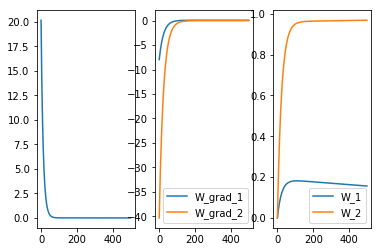

In [318]:
n = 500
loss1 = []
weights_grads_history = np.zeros((n, 2))
weights_history = np.zeros((n, 2))

for i in range(n):
    # You need to clear the existing gradients though, else gradients will be accumulated to existing gradients     
    optimizer.zero_grad()

    y_pred = toy(x)    
    loss = mse_loss(y_pred, y)
    # To backpropagate the error all we have to do is to loss.backward(). 
    loss.backward()

    loss1.append(loss.data[0])
    
    for f in toy.parameters():
        weights_grads_history[i, :] = f.grad.data.numpy()[:, 0]
        weights_history[i, :] = f.data.numpy()[:, 0]

    # Update parameters:
    optimizer.step()

print("n_iter", i)
print(loss1[-1])
print("y_pred: ", y_pred)
print("Weights : ", toy.weights)


plt.subplot(131)
plt.plot(range(n), loss1, label='loss')
plt.subplot(132)
plt.plot(range(n), weights_grads_history[:, 0], label='W_grad_1')
plt.plot(range(n), weights_grads_history[:, 1], label='W_grad_2')
plt.legend()
plt.subplot(133)
plt.plot(range(n), weights_history[:, 0], label='W_1')
plt.plot(range(n), weights_history[:, 1], label='W_2')
plt.legend()

## Neural networks

Modules `torch.nn` and `torch.nn.Module`


### Network architecture definition


Let's see how to create a convnet architecture:
```
gray scale  -- [Conv2D | Relu] -- [MaxPooling] -> [Conv2D | Relu] -- [MaxPooling] -> [Flatten] --
image input                             [FullyConnected | Relu] -- 
                                        [FullyConnected | Relu] -- 
                                        [FullyConnected ] -- output

```

Tensor channel order convention is `nSamples x nChannels x Height x Width`.


In [323]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self, input_size=(3, 32, 32)):
        super(Net, self).__init__()
        # Here we define network submodules
        # Submodules assigned in this way will be registered, and will have their
        # parameters converted too when you call .cuda(), etc.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        
        # As we have flatten before the first fully-connected layer
        # we need to compute input number of features:
        # 16 channels (output from conv2) x feature map width x feature map height
        self._fc1_in_features = int(16 * (((input_size[1] - 4) / 2 - 4) / 2) * (((input_size[2] - 4) / 2 - 4) / 2))
        
        self.fc1 = nn.Linear(in_features=self._fc1_in_features, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
            
    def forward(self, x):
        # Here we define network architecture
        # input  -- [Conv2D | Relu] -- [MaxPooling] ->
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(2, 2))

        #  -- [Conv2D | Relu] -- [MaxPooling] ->
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(2, 2)) # kernel_size can be defined also as kernel_size=2
        
        # Flatten
        
        x = x.view(-1, self._fc1_in_features)
        
        # [FullyConnected | Relu] -- [FullyConnected | Relu] -- [FullyConnected ] --
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = Fself.fc3(x)
        
        return x       

In [324]:
convnet = Net()
print(convnet)
params = list(convnet.parameters())
n_params = 0
for p in params:
    n = np.prod(p.size())
    print(n)
    n_params += n
print("Total number of parameters : %i" % n_params)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)
150
6
2400
16
48000
120
10080
84
840
10
Total number of parameters : 61706
